In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import mysql.connector
from mysql.connector import Error
import pandas as pd
from mysql.connector import Error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import LSTM_preprocessing as pre
import warnings
warnings.filterwarnings('ignore')

c:\Users\sghia\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
connection = pre.connect_to_database()
if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    # Close the connection
    pre.query_quit(connection)

merged_df.head(3)

Connected to MySQL database, MySQL Server version:  8.0.39
MySQL connection is closed


,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400


### merging with market cap

In [3]:
market_caps = pd.read_csv('market_cap_data.csv')
market_caps = market_caps.rename(columns={
    'timestamp': 'date',
    'token': 'crypto_symbol',
})
market_caps.head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
0,0,2020-12-21 00:00:00,87121414,1INCHUSDT
1,1,2020-12-21 01:00:00,87121414,1INCHUSDT
2,2,2020-12-21 02:00:00,87121414,1INCHUSDT


In [4]:
# Convert 'date' columns to pandas datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])
market_caps['date'] = pd.to_datetime(market_caps['date'])

# Perform the merge based on 'crypto_symbol' and 'date', keeping only rows in merged_df
merged_df.drop('market_cap', axis = 1, inplace=True)
merged_df = pd.merge(
    merged_df,
    market_caps[['date', 'market_cap', 'crypto_symbol']],
    on=['date', 'crypto_symbol'],
    how='left'
)

merged_df.head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,0.008552840317602313182744400,317700843.0
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,0.008552840317602313182744400,317700843.0
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,0.008552840317602313182744400,317700843.0


In [5]:
merged_df.isna().sum()

lending_rate               0
borrowing_rate             0
utilization_rate           0
stable_borrow_rate         0
crypto_symbol              0
date                       0
high                       0
low                        0
close                      0
adj_close                  0
volume                     0
coin_supply           487675
yield                      0
market_cap              5638
dtype: int64

In [6]:
merged_df[merged_df['market_cap'].isna()].head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
66770,-50.000000,-50.000000,-50.000000,0.030000,KNCUSDT,2020-12-02 14:00:00,1.02,1.01,1.01,1.01,66643,None,0.008552840317602313182744400,NaN
66771,-50.000000,-50.000000,-50.000000,0.030000,KNCUSDT,2020-12-02 15:00:00,1.01,1.00,1.01,1.01,81810,None,0.008552840317602313182744400,NaN
66772,-50.000000,-50.000000,0.333333,0.030000,KNCUSDT,2020-12-02 16:00:00,1.01,1.00,1.00,1.00,61898,None,0.008552840317602313182744400,NaN


In [7]:
market_caps[market_caps['crypto_symbol'] == 'KNCUSDT'].head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
226302,226302,2021-07-26 00:00:00,284924659,KNCUSDT
226303,226303,2021-07-26 01:00:00,284924659,KNCUSDT
226304,226304,2021-07-26 02:00:00,284924659,KNCUSDT


In [8]:
# KNC has wrong data before 2021
merged_df = merged_df[merged_df['market_cap'].notna()]
merged_df.reset_index(inplace = True, drop=True)

In [9]:
merged_df_emb = pre.create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)
merged_df_emb = pre.create_cyclical_encodings(merged_df_emb, "date")

In [10]:
merged_df_emb.columns

Index(['lending_rate', 'borrowing_rate', 'utilization_rate',
       'stable_borrow_rate', 'crypto_symbol', 'date', 'high', 'low', 'close',
       'adj_close', 'volume', 'coin_supply', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine'],
      dtype='object')

In [11]:
# data without NA rows if we needed 
filtered_df = merged_df_emb[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df['attention'] = filtered_df['volume'] * filtered_df['close']
filtered_df.drop(columns=['stable_borrow_rate','adj_close','coin_supply'], inplace=True)
filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)
filtered_df.reset_index(inplace=True, drop=True)
print(len(filtered_df))
filtered_df.columns

413705


Index(['lending_rate', 'borrowing_rate', 'utilization_rate', 'crypto_symbol',
       'date', 'high', 'low', 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention'],
      dtype='object')

In [12]:
# We scale  market cap, attention, yield together as they are comparable
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)
filtered_df['yield'] = scaler.fit_transform(filtered_df[['yield']])
filtered_df['market_cap'] = scaler.fit_transform(filtered_df[['market_cap']])
filtered_df['attention'] = scaler.fit_transform(filtered_df[['attention']])

In [13]:
outlier_threshold = "remove"
input_window = 48
output_window = 48
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine']

In [14]:
filtered_df.isna().sum()

lending_rate                  0
borrowing_rate                0
utilization_rate              0
crypto_symbol                 0
date                          0
high                          0
low                           0
close                         0
volume                        0
yield                         0
market_cap                    0
crypto_symbol_embedding_1     0
crypto_symbol_embedding_2     0
crypto_symbol_embedding_3     0
crypto_symbol_embedding_4     0
crypto_symbol_embedding_5     0
crypto_symbol_embedding_6     0
crypto_symbol_embedding_7     0
crypto_symbol_embedding_8     0
crypto_symbol_embedding_9     0
crypto_symbol_embedding_10    0
crypto_symbol_embedding_11    0
crypto_symbol_embedding_12    0
crypto_symbol_embedding_13    0
crypto_symbol_embedding_14    0
crypto_symbol_embedding_15    0
Month_Sine                    0
Month_Cosine                  0
Day_Sine                      0
Day_Cosine                    0
Hour_Sine                     0
Hour_Cos

In [15]:
# Initialize empty lists to store aggregated inputs and targets
X_train,X_valid,X_test = [], [], []
Y_train,Y_valid,Y_test = [], [], []

# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
for s in symbols:
     try:
          sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
          sim_df.reset_index(inplace=True, drop=True)
          print(s)
          # First Loop: Calculate intervals for each column without modifying the DataFrame
          intervals = {}
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
               intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

          # getting the returns
          reduced_df = sim_df.copy()
          reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
          reduced_df = reduced_df[reduced_df['returns'].notna()]
          reduced_df.reset_index(inplace=True, drop=True)

          # Second Loop: Filter rows based on the pre-calculated intervals
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower_bound = intervals[column]['lower_bound']
               upper_bound = intervals[column]['upper_bound']
               # Apply filtering based on pre-calculated bounds
               reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

          reduced_df.reset_index(inplace=True, drop=True)

          # MinMax scaling
          scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

          scaled_df = reduced_df.copy()
          scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
          scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
          scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
          scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
          scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
          scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

          inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(
               scaled_df,
               'date', 
               input_window, output_window, 
               input_columns, 
               ['lending_rate','borrowing_rate']
               ,train_end_date="2023-09-01 00:00:00", valid_end_date="2024-03-25 00:00:00")

          # Append results from the current DataFrame

          X_train.append(inputs_train)
          X_valid.append(inputs_valid)
          X_test.append(inputs_test)
          Y_train.append(targets_train)
          Y_valid.append(targets_valid)
          Y_test.append(targets_test)


     except Exception as e:
        # Handle any other exceptions
        print(f"Unexpected error in symbol {s}: {e}")

BATUSDT
LINKUSDT
KNCUSDT
MKRUSDT
MANAUSDT
ZRXUSDT
SNXUSDT
WBTCUSDT
ENJUSDT
RENUSDT
YFIUSDT
UNIUSDT
CRVUSDT
BALUSDT
ENSUSDT
1INCHUSDT


In [16]:
# Concatenate all inputs and targets into single arrays
X_train = [arr for arr in X_train if len(arr) > 0]
X_valid = [arr for arr in X_valid if len(arr) > 0]
X_test = [arr for arr in X_test if len(arr) > 0]

Y_train = [arr for arr in Y_train if len(arr) > 0]
Y_valid = [arr for arr in Y_valid if len(arr) > 0]
Y_test = [arr for arr in Y_test if len(arr) > 0]

X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])

In [17]:
# Lending rate
lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
# Borrowing rate
borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

In [52]:
print(borrow_rate_Y_train.shape)
print(borrow_rate_Y_valid.shape)
print(borrow_rate_Y_test.shape)

(103779, 1)
(46107, 1)
(45991, 1)


In [46]:
def balanced_weights(array):
    unique_classes, counts = np.unique(array, return_counts=True)
    row_n = sum(counts)
    weights = [(y/row_n) for y in counts]
    raw_weights = [1.0 / freq for freq in weights]
    normalized_weights = [w / np.mean(raw_weights) for w in raw_weights]
    # Convert to dictionary with class indices as keys
    weights_dict = {i: weight for i, weight in enumerate(normalized_weights)}
    return weights_dict

weights = balanced_weights(borrow_rate_Y_train)
weights_valid = balanced_weights(borrow_rate_Y_valid)
weights_test = balanced_weights(borrow_rate_Y_test)

print(weights)
print(weights_valid)
print(weights_test)

{0: 0.7746333934760854, 1: 0.9825799318515227, 2: 1.2427866746723923}
{0: 0.2476658243551267, 1: 0.8845401583270966, 2: 1.8677940173177765}
{0: 0.24993627584137218, 1: 1.3184715386818997, 2: 1.431592185476728}


In [25]:
import numpy as np
from sklearn.metrics import f1_score

# Assume Y_test is your true sequential labels
Y_test = borrow_rate_Y_test  # Example sequential data

# Number of bootstrap iterations
num_simulations = 10000

# Get class distribution from Y_test
unique, counts = np.unique(Y_test, return_counts=True)
class_probs = counts / len(Y_test)

# Function to simulate one random guessing sequence
def random_guess_sequence(Y_test, class_probs=weights):
    if class_probs is None:
        # Uniform random guessing
        predictions = np.random.choice([0, 1, 2], size=len(Y_test))
    else:
        # Distribution-based random guessing
        predictions = np.random.choice([0, 1, 2], size=len(Y_test), p=class_probs)
    return predictions

# Simulate random guessing and compute Mean F1 scores
f1_scores = []
for _ in range(num_simulations):
    random_preds = random_guess_sequence(Y_test, class_probs=[0.4146503627901599, 0.32689657830582297, 0.2584530589040172])  # Change `class_probs=None` for uniform
    f1 = f1_score(Y_test, random_preds, average='macro')  # Macro F1 for equal weighting across classes
    f1_scores.append(f1)

# Calculate average and confidence interval of F1 scores
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
conf_interval = (mean_f1 - 1.96 * std_f1 / np.sqrt(num_simulations),
                 mean_f1 + 1.96 * std_f1 / np.sqrt(num_simulations))

# Print results
print(f"Mean F1 Score (Random Guessing): {mean_f1:.4f}")
print(f"95% Confidence Interval: [{conf_interval[0]:.4f}, {conf_interval[1]:.4f}]")


Mean F1 Score (Random Guessing): 0.2986
95% Confidence Interval: [0.2986, 0.2987]


In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal

def Attention_model(X_train,X_valid,X_test,Y_train,Y_valid,Y_test,weights,weights_valid, epochs=10,
                     batch_size=100, d1=0.1, d2 = 0.05, cell_size = 80, attention_heads=4):

    tf.keras.backend.clear_session()
    n_classes = 3

    cell_size_1 = cell_size
    cell_size_2 = cell_size_1//2

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    attention_layer_1 = MultiHeadAttention(
    num_heads=attention_heads,
    key_dim=cell_size)(
    query=inputs,
    key=inputs,
    value=inputs)
    residual_1 = Add()([inputs, attention_layer_1])  # Add residual connection
    norm_1 = LayerNormalization()(residual_1)

    attention_layer_2 = MultiHeadAttention(
    num_heads=attention_heads,
    key_dim=cell_size)(
    query=norm_1,
    key=norm_1,
    value=norm_1)
    residual_2 = Add()([norm_1, attention_layer_2])
    norm_2 = LayerNormalization()(residual_2)
    dropout_1 = Dropout(d1)(norm_2)

    ffw = Dense(cell_size_2, activation="swish", kernel_initializer=HeNormal())(dropout_1)
    dropout_2 = Dropout(d2)(ffw)
    flatten_ = Flatten()(dropout_2)
    ffw_2 = Dense(cell_size_2,activation="swish", kernel_initializer=HeNormal())(flatten_)

    class_predictions = Dense(n_classes, activation='softmax',name="class", kernel_initializer=HeNormal())(ffw_2)
    Attention_base = Model(inputs=inputs, outputs=class_predictions)

    # we will keep this as a standardized learning rate optimizer across all models
    optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7)      # Default , to prevent division by zero)

    Attention_base.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    Attention_base.summary()

    class WeightedValidationLossCallback(tf.keras.callbacks.Callback):
        def __init__(self, validation_data, class_weights, save_best_model=True, model_save_path="best_model.keras"):
            super().__init__()
            self.validation_data = validation_data
            self.class_weights = class_weights
            self.save_best_model = save_best_model
            self.model_save_path = model_save_path
            self.best_val_loss = float('inf')  # Initialize to a very high value

        def on_epoch_end(self, epoch, logs=None):
            val_x, val_y = self.validation_data
            val_pred = self.model.predict(val_x, batch_size=batch_size)
            val_loss = self.compute_weighted_loss(val_y, val_pred)
            print(f"Epoch {epoch + 1} - Weighted Validation Loss: {val_loss:.4f}")
        
            if self.save_best_model and val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                # Save the model with the best validation loss
                self.model.save(self.model_save_path)
                print(f"New best model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}")

        def compute_weighted_loss(self, y_true, y_pred):
            loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
            sample_weights = np.array([self.class_weights[np.argmax(label)] for label in y_true])
            unweighted_loss = loss_fn(y_true, y_pred)
            weighted_loss = tf.reduce_mean(unweighted_loss * sample_weights)
            return weighted_loss

    callback = WeightedValidationLossCallback(
    validation_data=(X_valid, Y_valid),
    class_weights=weights_valid,
    save_best_model=True,  # Set to False if you don't want to save the best model
    model_save_path="best_model.keras"  # Specify where to save the best model
    )

    # Pass the callback during training
    history = Attention_base.fit(
    x=X_train, y=Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=weights,
    shuffle=False,
    callbacks=[callback])


    fig, ax1 = plt.subplots()

    # Plot losses on the primary y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history.history['loss'], label='Train Loss', color='red', linestyle='-')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Combine legends from both axes
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)  # Legend outside the plot

    plt.title('Model Accuracy and Loss')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

    y_pred = Attention_base.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)

    return Y_test, y_pred

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 30)    │     39,390 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 30)    │          0 │ input_layer[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 30)    │         60 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 30)    │     39,390 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 30)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 30)    │         60 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 30)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 48, 40)    │      1,240 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 40)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1920)      │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40)        │     76,840 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (Dense)       │ (None, 3)         │        123 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,103 (613.68 KB)

 Trainable params: 157,103 (613.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step
Epoch 1 - Weighted Validation Loss: 0.2101
New best model saved at epoch 1 with validation loss: 0.2101
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 114s 105ms/step - accuracy: 0.5548 - loss: 0.8827 - val_accuracy: 0.7079 - val_loss: 0.8483
Epoch 2/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step
Epoch 2 - Weighted Validation Loss: 0.2059
New best model saved at epoch 2 with validation loss: 0.2059
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 107s 103ms/step - accuracy: 0.5760 - loss: 0.8427 - val_accuracy: 0.7079 - val_loss: 0.8315
Epoch 3/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step
Epoch 3 - Weighted Validation Loss: 0.1930
New best model saved at epoch 3 with validation loss: 0.1930
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 108s 104ms/step - accuracy: 0.5702 - loss: 0.8423 - val_accuracy: 0.7070 - val_loss: 0.7795
Epoch 4/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step
Epoch 4 - Weighted Validation Loss: 0.1895
New best model saved at epoch 4 with validation loss: 0.1895

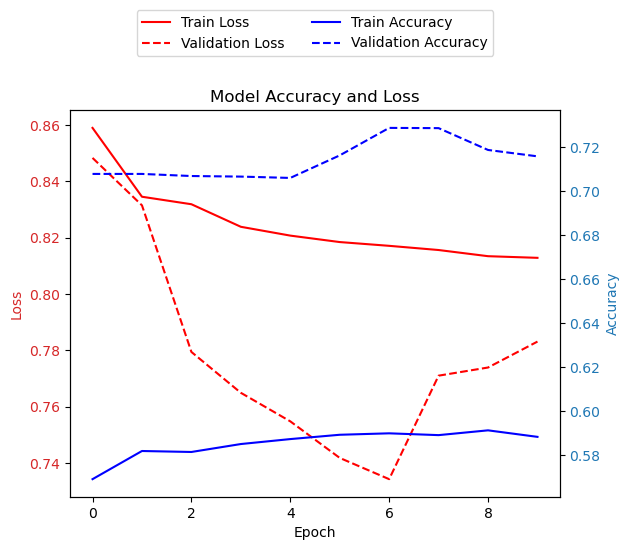

1438/1438 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


In [63]:
# sample model
Y_test, y_pred = Attention_model(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test,weights,weights_valid)

In [64]:
best_model = tf.keras.models.load_model('best_model.keras')

y_pred_best = best_model.predict(X_test)
y_pred_best = np.argmax(y_pred_best, axis=-1)

1438/1438 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step


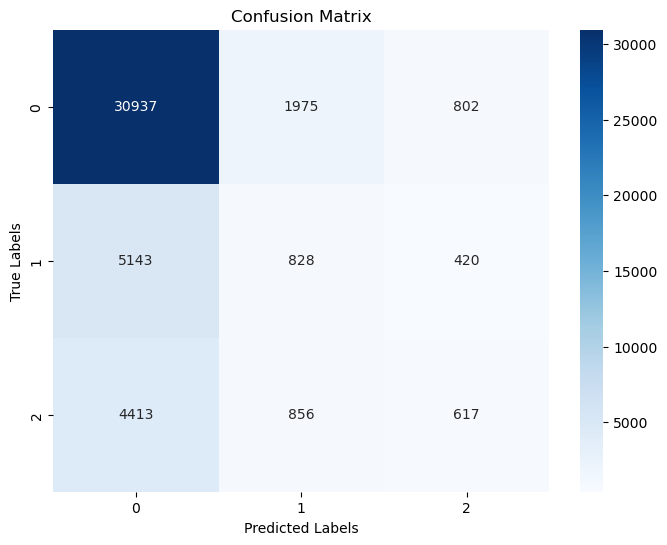

Classification Metrics:
Accuracy: 0.70
Precision: 0.44
Recall: 0.38
F1 Score: 0.39

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     33714
           1       0.23      0.13      0.16      6391
           2       0.34      0.10      0.16      5886

    accuracy                           0.70     45991
   macro avg       0.44      0.38      0.39     45991
weighted avg       0.63      0.70      0.65     45991

(0.7040942793155183, 0.44193611966748475, 0.38400428539327275, 0.38610665356930624)


In [67]:
# this should work as well
print(pre.classification_metrics(borrow_rate_Y_test, y_pred, printed = True))

### Performing Grid-search on the base arcitecture, with all inputs

In [16]:
outlier_threshold_list = [0.75, 1.5, 3, 'remove']
input_output_combination_1 = [
     {'input':8, 'output':8},
     {'input':24, 'output':8},
     {'input':24, 'output':24},
     {'input':48, 'output':8},
     {'input':48, 'output':24},
     {'input':48, 'output':48},
     {'input':96, 'output':8},

]
input_output_combination_2 = [
     {'input':96, 'output':24},
     {'input':96, 'output':48},
     {'input':96, 'output':96},
     {'input':192, 'output':8},
     {'input':192, 'output':24},
     {'input':192, 'output':48},
     {'input':192, 'output':96},
     {'input':192, 'output':192},
]
epoch_num = 100
bacth_size = 200
# d1 = [0.1,0.3]
# d2 = [0.05, 0.15]
d1 = 0.1
d2 = 0.05
# 
cell_size = 80

In [ ]:
results_arr_1 = []
for outlier_threshold in outlier_threshold_list:
     for comb in input_output_combination_1:
          try:
               print('preprocessing...')
               input_window = comb['input'] #***
               output_window = comb['output'] #***

               # Initialize empty lists to store aggregated inputs and targets
               all_inputs = []
               all_targets = []

               # looping through symbols
               symbols = filtered_df['crypto_symbol'].unique()
               for s in symbols:
                    try:
                         sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                         sim_df.reset_index(inplace=True, drop=True)
                         # First Loop: Calculate intervals for each column without modifying the DataFrame
                         intervals = {}
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                              intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                         # getting the returns
                         reduced_df = sim_df.copy()
                         reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                         reduced_df = reduced_df[reduced_df['returns'].notna()]
                         reduced_df.reset_index(inplace=True, drop=True)

                         # Second Loop: Filter rows based on the pre-calculated intervals
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower_bound = intervals[column]['lower_bound']
                              upper_bound = intervals[column]['upper_bound']
                              # Apply filtering based on pre-calculated bounds
                              reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                         reduced_df.reset_index(inplace=True, drop=True)

                         # MinMax scaling
                         scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                         scaled_df = reduced_df.copy()
                         scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                         scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                         scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                         scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                         scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                         scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                         inputs, targets = pre.extract_valid_windows_v2(
                              scaled_df,
                              'date', 
                              input_window, output_window, 
                              input_columns, 
                              ['lending_rate','borrowing_rate']
                              )

                         # Append results from the current DataFrame
                         all_inputs.append(inputs)
                         all_targets.append(targets)
                    except Exception as e:
                         # Handle any other exceptions
                         print(f"Unexpected error in symbol {s}: {e}")

               # Concatenate all inputs and targets into single arrays
               all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
               all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])

               # Lending rate
               output_1 = all_targets[:, 0].reshape(all_targets.shape[0], 1) 
               # Borrowing rate
               output_2 = all_targets[:, 1].reshape(all_targets.shape[0], 1) 
               total_windows = output_1.shape[0] #***
               print('training ...')
               y_test, y_pred = train_v1(all_inputs, output_1, details=False)
               
               accuracy, precision, recall, f1 = pre.classification_metrics(y_test, y_pred, printed = False)

               new_row = {
                    'total_windows':total_windows,
                    'input_window':input_window,
                    'output_window':output_window, 
                    'outlier_threshold':outlier_threshold, 
                    'accuracy':accuracy, 
                    'precision':precision, 
                    'recall':recall, 
                    'f1':f1
               }
               results_arr_1.append(new_row)
               print(new_row)
               
          except Exception as e:
               print(f"Error occurred with outlier_threshold={outlier_threshold}, comb={comb}")
               print(f"Exception details: {e}")

results_1 = pd.DataFrame(results_arr_1)
     

In [21]:
results_1.to_csv('result_checkpoint_1.csv')

### in parallel the scond results

In [ ]:
results_arr_2 = []
for outlier_threshold in outlier_threshold_list:
     for comb in input_output_combination_2:
          try:
               print('preprocessing...')
               input_window = comb['input'] #***
               output_window = comb['output'] #***

               # Initialize empty lists to store aggregated inputs and targets
               all_inputs = []
               all_targets = []

               # looping through symbols
               symbols = filtered_df['crypto_symbol'].unique()
               for s in symbols:
                    try:
                         sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                         sim_df.reset_index(inplace=True, drop=True)
                         # First Loop: Calculate intervals for each column without modifying the DataFrame
                         intervals = {}
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                              intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                         # getting the returns
                         reduced_df = sim_df.copy()
                         reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                         reduced_df = reduced_df[reduced_df['returns'].notna()]
                         reduced_df.reset_index(inplace=True, drop=True)

                         # Second Loop: Filter rows based on the pre-calculated intervals
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower_bound = intervals[column]['lower_bound']
                              upper_bound = intervals[column]['upper_bound']
                              # Apply filtering based on pre-calculated bounds
                              reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                         reduced_df.reset_index(inplace=True, drop=True)

                         # MinMax scaling
                         scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                         scaled_df = reduced_df.copy()
                         scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                         scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                         scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                         scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                         scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                         scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                         inputs, targets = pre.extract_valid_windows_v2(
                              scaled_df,
                              'date', 
                              input_window, output_window, 
                              input_columns, 
                              ['lending_rate','borrowing_rate']
                              )

                         # Append results from the current DataFrame
                         all_inputs.append(inputs)
                         all_targets.append(targets)
                    except Exception as e:
                         # Handle any other exceptions
                         print(f"Unexpected error in symbol {s}: {e}")

               # Concatenate all inputs and targets into single arrays
               all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
               all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])

               # Lending rate
               output_1 = all_targets[:, 0].reshape(all_targets.shape[0], 1) 
               # Borrowing rate
               output_2 = all_targets[:, 1].reshape(all_targets.shape[0], 1) 
               total_windows = output_1.shape[0] #***
               print('training ...')
               y_test, y_pred = train_v1(all_inputs, output_1, details=False)
               
               accuracy, precision, recall, f1 = pre.classification_metrics(y_test, y_pred, printed = False)

               new_row = {
                    'total_windows':total_windows,
                    'input_window':input_window,
                    'output_window':output_window, 
                    'outlier_threshold':outlier_threshold, 
                    'accuracy':accuracy, 
                    'precision':precision, 
                    'recall':recall, 
                    'f1':f1
               }
               results_arr_2.append(new_row)
               print(new_row)
          except:
               print('error occured: ', outlier_threshold, comb)

results_2 = pd.DataFrame(results_arr_2)

In [ ]:
results_2.to_csv('result_checkpoint_2.csv')

In [25]:
outlier_threshold_list_2 = [1.5, 3, 'remove']
input_output_combination_2 = [
     {'input':96, 'output':24},
     {'input':96, 'output':48},
     {'input':96, 'output':96},
     {'input':192, 'output':8},
     {'input':192, 'output':24},
     {'input':192, 'output':48},
     {'input':192, 'output':96},
     {'input':192, 'output':192},
]

In [26]:
results_arr_3 = []
for outlier_threshold in outlier_threshold_list_2:
     for comb in input_output_combination_2:
          try:
               print('preprocessing...')
               input_window = comb['input'] #***
               output_window = comb['output'] #***

               # Initialize empty lists to store aggregated inputs and targets
               all_inputs = []
               all_targets = []

               # looping through symbols
               symbols = filtered_df['crypto_symbol'].unique()
               for s in symbols:
                    try:
                         sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                         sim_df.reset_index(inplace=True, drop=True)
                         # First Loop: Calculate intervals for each column without modifying the DataFrame
                         intervals = {}
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                              intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                         # getting the returns
                         reduced_df = sim_df.copy()
                         reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                         reduced_df = reduced_df[reduced_df['returns'].notna()]
                         reduced_df.reset_index(inplace=True, drop=True)

                         # Second Loop: Filter rows based on the pre-calculated intervals
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower_bound = intervals[column]['lower_bound']
                              upper_bound = intervals[column]['upper_bound']
                              # Apply filtering based on pre-calculated bounds
                              reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                         reduced_df.reset_index(inplace=True, drop=True)

                         # MinMax scaling
                         scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                         scaled_df = reduced_df.copy()
                         scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                         scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                         scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                         scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                         scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                         scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                         inputs, targets = pre.extract_valid_windows_v2(
                              scaled_df,
                              'date', 
                              input_window, output_window, 
                              input_columns, 
                              ['lending_rate','borrowing_rate']
                              )

                         # Append results from the current DataFrame
                         if len(inputs.shape) == 3:
                              all_inputs.append(inputs)
                              all_targets.append(targets)
                    except Exception as e:
                         # Handle any other exceptions
                         print(f"Unexpected error in symbol {s}: {e}")

               # Concatenate all inputs and targets into single arrays
               all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
               all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])

               # Lending rate
               output_1 = all_targets[:, 0].reshape(all_targets.shape[0], 1) 
               # Borrowing rate
               output_2 = all_targets[:, 1].reshape(all_targets.shape[0], 1) 
               total_windows = output_1.shape[0] #***
               print('training ...')
               y_test, y_pred = train_v1(all_inputs, output_1, details=False)
               
               accuracy, precision, recall, f1 = pre.classification_metrics(y_test, y_pred, printed = False)

               new_row = {
                    'total_windows':total_windows,
                    'input_window':input_window,
                    'output_window':output_window, 
                    'outlier_threshold':outlier_threshold, 
                    'accuracy':accuracy, 
                    'precision':precision, 
                    'recall':recall, 
                    'f1':f1
               }
               results_arr_3.append(new_row)
               print(new_row)
               
          except Exception as e:
               print(f"Error occurred with outlier_threshold={outlier_threshold}, comb={comb}")
               print(f"Exception details: {e}")

results_3 = pd.DataFrame(results_arr_3)

preprocessing...
training ...



361/361 [==============================] - 6s 13ms/step
{'total_windows': 57703, 'input_window': 96, 'output_window': 24, 'outlier_threshold': 1.5, 'accuracy': 0.941772809981804, 'precision': 0.9102707827214775, 'recall': 0.905662887849609, 'f1': 0.9077584993383985}
preprocessing...
training ...
311/311 [==============================] - 5s 14ms/step
{'total_windows': 49631, 'input_window': 96, 'output_window': 48, 'outlier_threshold': 1.5, 'accuracy': 0.9615190893522716, 'precision': 0.9467083387595263, 'recall': 0.9443150294252839, 'f1': 0.945412410174525}
preprocessing...
training ...
241/241 [==============================] - 4s 13ms/step
{'total_windows': 38559, 'input_window': 96, 'output_window': 96, 'outlier_threshold': 1.5, 'accuracy': 0.9712136929460581, 'precision': 0.9653892586529186, 'recall': 0.9622964352261674, 'f1': 0.9638190358047286}
preprocessing...
training ...
233/233 [==============================] - 9s 34ms/step
{'total_windows':

In [27]:
results_3.to_csv('result_checkpoint_3.csv')

In [3]:
results_concatenated_arr = [
  {
    "total_windows": 161498,
    "input_window": 8,
    "output_window": 8,
    "outlier_threshold": 0.75,
    "accuracy": 0.805015479876161,
    "precision": 0.7284011900080548,
    "recall": 0.7190092300602431,
    "f1": 0.7231271786440341
  },
  {
    "total_windows": 124197,
    "input_window": 24,
    "output_window": 8,
    "outlier_threshold": 0.75,
    "accuracy": 0.8478260869565217,
    "precision": 0.7646140580814885,
    "recall": 0.7679676838027246,
    "f1": 0.7662746885640611
  },
  {
    "total_windows": 100134,
    "input_window": 24,
    "output_window": 24,
    "outlier_threshold": 0.75,
    "accuracy": 0.9088230888300793,
    "precision": 0.8849807940783556,
    "recall": 0.889388405908531,
    "f1": 0.8870731188952945
  },
  {
    "total_windows": 91103,
    "input_window": 48,
    "output_window": 8,
    "outlier_threshold": 0.75,
    "accuracy": 0.8783272048734976,
    "precision": 0.7825322435256802,
    "recall": 0.7775991998766544,
    "f1": 0.7800197978434812
  },
  {
    "total_windows": 77235,
    "input_window": 48,
    "output_window": 24,
    "outlier_threshold": 0.75,
    "accuracy": 0.923350812455493,
    "precision": 0.8929993454627488,
    "recall": 0.895331808169141,
    "f1": 0.8941578036607063
  },
  {
    "total_windows": 179161,
    "input_window": 8,
    "output_window": 8,
    "outlier_threshold": 1.5,
    "accuracy": 0.7946027404906092,
    "precision": 0.7178000873108198,
    "recall": 0.7154863783565976,
    "f1": 0.7166077021522463
  },
  {
    "total_windows": 137341,
    "input_window": 24,
    "output_window": 8,
    "outlier_threshold": 1.5,
    "accuracy": 0.8408751683716189,
    "precision": 0.7593802654542022,
    "recall": 0.7539271600604186,
    "f1": 0.7565955031191778
  },
  {
    "total_windows": 110558,
    "input_window": 24,
    "output_window": 24,
    "outlier_threshold": 1.5,
    "accuracy": 0.9046671490593343,
    "precision": 0.8848388380805025,
    "recall": 0.88546197918045,
    "f1": 0.8851292469253433
  },
  {
    "total_windows": 100542,
    "input_window": 48,
    "output_window": 8,
    "outlier_threshold": 1.5,
    "accuracy": 0.8718484260778756,
    "precision": 0.7786834923730629,
    "recall": 0.7767844231011746,
    "f1": 0.7775423808435405
  },
  {
    "total_windows": 84910,
    "input_window": 48,
    "output_window": 24,
    "outlier_threshold": 1.5,
    "accuracy": 0.9157931927923684,
    "precision": 0.890195486808082,
    "recall": 0.8871248905370995,
    "f1": 0.8885651088239648
  },
  {
    "total_windows": 68870,
    "input_window": 48,
    "output_window": 48,
    "outlier_threshold": 1.5,
    "accuracy": 0.9468563961086104,
    "precision": 0.9328646637688895,
    "recall": 0.9337874166962549,
    "f1": 0.9333236753739161
  },
  {
    "total_windows": 64776,
    "input_window": 96,
    "output_window": 8,
    "outlier_threshold": 1.5,
    "accuracy": 0.9092312442111763,
    "precision": 0.7968661027685858,
    "recall": 0.792474382288364,
    "f1": 0.7946096168183244
  },
  {
    "total_windows": 201229,
    "input_window": 8,
    "output_window": 8,
    "outlier_threshold": 3,
    "accuracy": 0.7776673458231874,
    "precision": 0.7028578382743317,
    "recall": 0.6961036363974299,
    "f1": 0.6992636285647423
  },
  {
    "total_windows": 155219,
    "input_window": 24,
    "output_window": 8,
    "outlier_threshold": 3,
    "accuracy": 0.8331722716144827,
    "precision": 0.7517576293640871,
    "recall": 0.7520766111176863,
    "f1": 0.7516185883284967
  },
  {
    "total_windows": 125552,
    "input_window": 24,
    "output_window": 24,
    "outlier_threshold": 3,
    "accuracy": 0.9035084226036398,
    "precision": 0.8822501243041315,
    "recall": 0.8821800999157322,
    "f1": 0.8820922198883901
  },
  {
    "total_windows": 114421,
    "input_window": 48,
    "output_window": 8,
    "outlier_threshold": 3,
    "accuracy": 0.8680358313305658,
    "precision": 0.7739353650446459,
    "recall": 0.7689067692072514,
    "f1": 0.7713383152131982
  },
  {
    "total_windows": 97078,
    "input_window": 48,
    "output_window": 24,
    "outlier_threshold": 3,
    "accuracy": 0.9163061392665842,
    "precision": 0.8858487505000618,
    "recall": 0.8895175900463346,
    "f1": 0.8876587406951829
  },
  {
    "total_windows": 79137,
    "input_window": 48,
    "output_window": 48,
    "outlier_threshold": 3,
    "accuracy": 0.9506570634318928,
    "precision": 0.9382847813878942,
    "recall": 0.9375977426717453,
    "f1": 0.9379373966116603
  },
  {
    "total_windows": 74605,
    "input_window": 96,
    "output_window": 8,
    "outlier_threshold": 3,
    "accuracy": 0.9071778030963072,
    "precision": 0.8002947754064235,
    "recall": 0.7807430599581292,
    "f1": 0.789916056104009
  },
  {
    "total_windows": 327875,
    "input_window": 8,
    "output_window": 8,
    "outlier_threshold": "remove",
    "accuracy": 0.8200686237133054,
    "precision": 0.7066615593219886,
    "recall": 0.6960312162211983,
    "f1": 0.700878606522123
  },
  {
    "total_windows": 273290,
    "input_window": 24,
    "output_window": 8,
    "outlier_threshold": "remove",
    "accuracy": 0.8605876541402905,
    "precision": 0.738147433332408,
    "recall": 0.742869896290912,
    "f1": 0.7404472312905543
  },
  {
    "total_windows": 235083,
    "input_window": 24,
    "output_window": 24,
    "outlier_threshold": "remove",
    "accuracy": 0.9186464470297977,
    "precision": 0.874485319125894,
    "recall": 0.8784571710543391,
    "f1": 0.8763867778181978
  },
  {
    "total_windows": 220131,
    "input_window": 48,
    "output_window": 8,
    "outlier_threshold": "remove",
    "accuracy": 0.8924523587798396,
    "precision": 0.7571354256846973,
    "recall": 0.7568231267134687,
    "f1": 0.7568448751184067
  },
  {
    "total_windows": 195877,
    "input_window": 48,
    "output_window": 24,
    "outlier_threshold": "remove",
    "accuracy": 0.9319991831733715,
    "precision": 0.881989144528569,
    "recall": 0.8843984070060519,
    "f1": 0.8831319284125021
  },
  {
    "total_windows": 169235,
    "input_window": 48,
    "output_window": 48,
    "outlier_threshold": "remove",
    "accuracy": 0.9563624545749992,
    "precision": 0.9308015465456978,
    "recall": 0.9283919386004099,
    "f1": 0.9295685481353487
  },
  {
    "total_windows": 162173,
    "input_window": 96,
    "output_window": 8,
    "outlier_threshold": "remove",
    "accuracy": 0.9324495144134423,
    "precision": 0.7899275540037598,
    "recall": 0.7907096232200033,
    "f1": 0.7897159132510603
  },
  {
    "total_windows": 66758,
    "input_window": 96,
    "output_window": 24,
    "outlier_threshold": 3,
    "accuracy": 0.9397843019772318,
    "precision": 0.899019400087241,
    "recall": 0.9050565919834498,
    "f1": 0.9020000998565806
  },
  {
    "total_windows": 53227,
    "input_window": 96,
    "output_window": 24,
    "outlier_threshold": 0.75,
    "accuracy": 0.9418560961863611,
    "precision": 0.89923975048056,
    "recall": 0.906111031300608,
    "f1": 0.9026333239536019
  },
  {
    "total_windows": 45984,
    "input_window": 96,
    "output_window": 48,
    "outlier_threshold": 0.75,
    "accuracy": 0.9621615744264435,
    "precision": 0.9444138041778123,
    "recall": 0.9428562411454987,
    "f1": 0.9436259704754105
  },
  {
    "total_windows": 35866,
    "input_window": 96,
    "output_window": 96,
    "outlier_threshold": 0.75,
    "accuracy": 0.9669640367995539,
    "precision": 0.955762053714996,
    "recall": 0.9559345777197411,
    "f1": 0.9558476506983267
  },
  {
    "total_windows": 34585,
    "input_window": 192,
    "output_window": 8,
    "outlier_threshold": 0.75,
    "accuracy": 0.9491108862223507,
    "precision": 0.8205994545003411,
    "recall": 0.8090738530689082,
    "f1": 0.8143141985585783
  },
  {
    "total_windows": 32247,
    "input_window": 192,
    "output_window": 24,
    "outlier_threshold": 0.75,
    "accuracy": 0.958139534883721,
    "precision": 0.9117928158005415,
    "recall": 0.9227112038818134,
    "f1": 0.9170946758488622
  },
  {
    "total_windows": 29222,
    "input_window": 192,
    "output_window": 48,
    "outlier_threshold": 0.75,
    "accuracy": 0.9714285714285714,
    "precision": 0.9489725231419216,
    "recall": 0.9501371711916632,
    "f1": 0.949553715257267
  },
  {
    "total_windows": 24302,
    "input_window": 192,
    "output_window": 96,
    "outlier_threshold": 0.75,
    "accuracy": 0.9753137214564904,
    "precision": 0.9658347638374188,
    "recall": 0.9591429921629375,
    "f1": 0.962380111113
  },
  {
    "total_windows": 17133,
    "input_window": 192,
    "output_window": 192,
    "outlier_threshold": 0.75,
    "accuracy": 0.983659177122848,
    "precision": 0.977814518176308,
    "recall": 0.9779319455265704,
    "f1": 0.9778683567235623
  }
]


results_concatenated = pd.DataFrame(results_concatenated_arr)
results_concatenated

,total_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,161498,8,8,0.75,0.805015,0.728401,0.719009,0.723127
1,124197,24,8,0.75,0.847826,0.764614,0.767968,0.766275
2,100134,24,24,0.75,0.908823,0.884981,0.889388,0.887073
3,91103,48,8,0.75,0.878327,0.782532,0.777599,0.780020
4,77235,48,24,0.75,0.923351,0.892999,0.895332,0.894158
5,179161,8,8,1.5,0.794603,0.717800,0.715486,0.716608
6,137341,24,8,1.5,0.840875,0.759380,0.753927,0.756596
7,110558,24,24,1.5,0.904667,0.884839,0.885462,0.885129
8,100542,48,8,1.5,0.871848,0.778683,0.776784,0.777542
9,84910,48,24,1.5,0.915793,0.890195,0.887125,0.888565


In [4]:
results_concatenated.to_excel('results_concatenated.xlsx')

Correlation: -0.6495605621661548


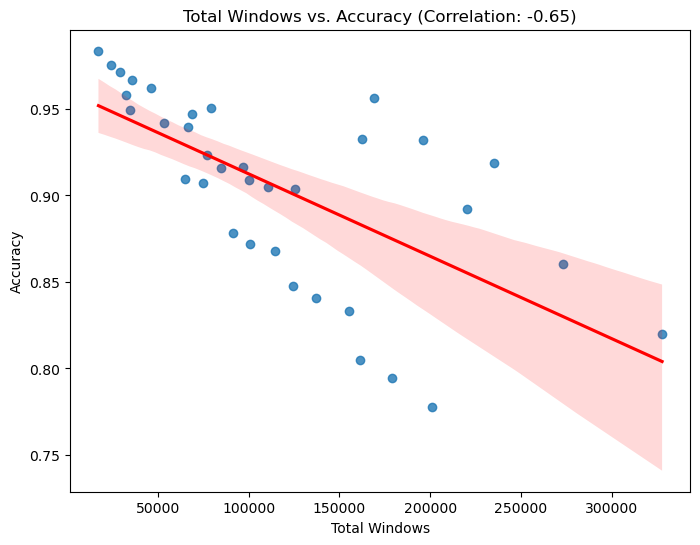

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate correlation between length and accuracy
correlation = results_concatenated['total_windows'].corr(results_concatenated['accuracy'])
print("Correlation:", correlation)

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='total_windows', y='accuracy', data=results_concatenated, line_kws={'color': 'red'})
plt.title(f"Total Windows vs. Accuracy (Correlation: {correlation:.2f})")
plt.xlabel('Total Windows')
plt.ylabel('Accuracy')
plt.show()


Correlation: 0.7165450560628177


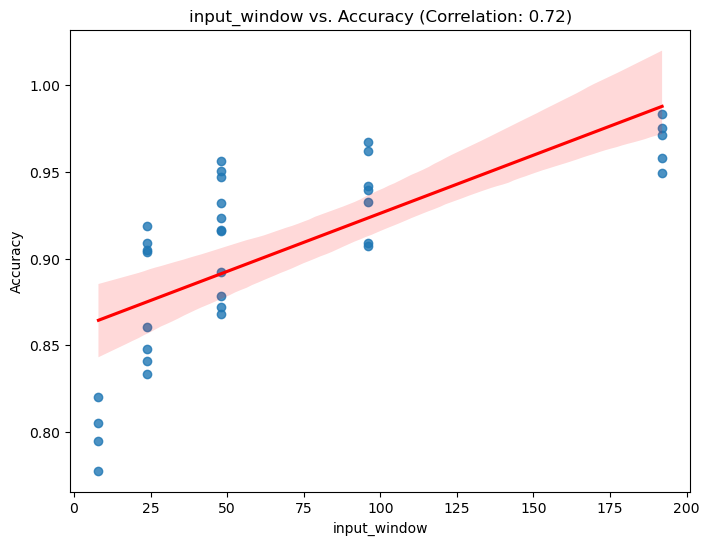

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate correlation between input_window and accuracy
correlation = results_concatenated['input_window'].corr(results_concatenated['accuracy'])
print("Correlation:", correlation)

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='input_window', y='accuracy', data=results_concatenated, line_kws={'color': 'red'})
plt.title(f"input_window vs. Accuracy (Correlation: {correlation:.2f})")
plt.xlabel('input_window')
plt.ylabel('Accuracy')
plt.show()

Correlation: 0.5941822422928894


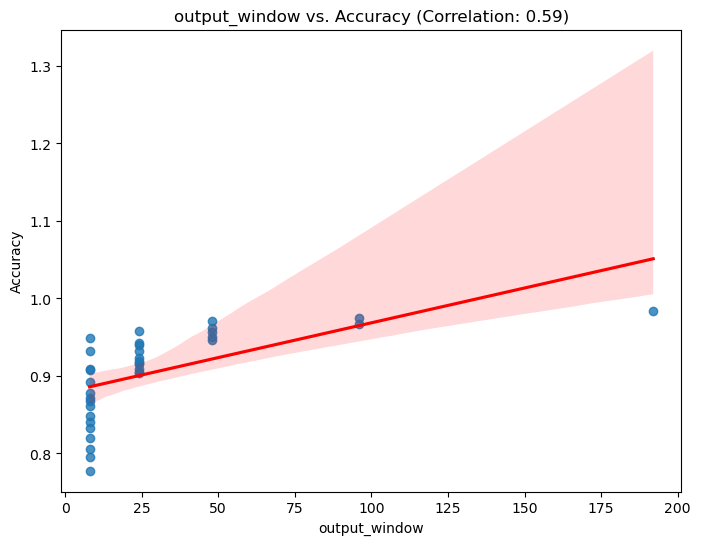

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate correlation between output_window and accuracy
correlation = results_concatenated['output_window'].corr(results_concatenated['accuracy'])
print("Correlation:", correlation)

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='output_window', y='accuracy', data=results_concatenated, line_kws={'color': 'red'})
plt.title(f"output_window vs. Accuracy (Correlation: {correlation:.2f})")
plt.xlabel('output_window')
plt.ylabel('Accuracy')
plt.show()